# **helper functions for specificity and sensitivity**

In [ ]:
def calc_specificity(tn, fp, fn, tp):
  return tn / (tn +fp)

In [ ]:
def calc_sensitivity(tn, fp, fn, tp):
  return tp / (tp +fn)

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    # print(TN, FP, FN, TP)
    return(TN, FP, FN, TP)

In [ ]:
def calcCrossValidation_Matrix(model, df, predictors, outcome):

  total_tp = 0
  total_tn = 0
  total_fp = 0
  total_fn = 0

  # Perform k-fold cross-validation with 10 folds
  kf = KFold(n_splits=df.shape[0])
  accuracy = []
  for train, test in kf.split(df):
      # print("1")

      # Filter training data
      train_predictors = (df[predictors].iloc[train, :])
      # The target we're using to train the algorithm.
      train_target = df[outcome].iloc[train]
      # print("1")

      test_predictors = (df[predictors].iloc[test, :])
      # The target we're using to train the algorithm.
      test_target = df[outcome].iloc[test]
      # print("1")


      # Training the algorithm using the predictors and target.
      model.fit(train_predictors, train_target)
      predictions = model.predict(test_predictors)
      # cm = confusion_matrix(test_target, predictions)
      # print(cm)
      # print("1")
      # print("test_target")
      test_target = test_target.to_numpy()
      # print(test_target)
      # np.array(df[outcome].values.tolist())
      # print(type(test_target))
      # print("predictions")
      # print(predictions)
      # print(type(predictions))

      tn, fp, fn, tp = perf_measure(test_target, predictions)
      # print("1")

      total_tp += tp
      total_tn += tn
      total_fp += fp
      total_fn += fn

  # print(total_tn, total_fp, total_fn, total_tp)
  return total_tn, total_fp, total_fn, total_tp 

**sklearn linear_model Lasso**

#**data preperation**

import all the relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import io
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


upload the db file

In [ ]:

from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


untreated

In [ ]:
df_all_treated = pd.read_pickle("/content/gdrive/My Drive/Colab Notebooks/MS_Notebooks/DF_all_treated.pkl")
df_all_treated

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


normalization

In [ ]:
def min_max_normalize_features(dataframe, numeric_list):
    for num_feature in numeric_list:
        dataframe[num_feature] = (dataframe[num_feature] - dataframe[num_feature].min()) / (
                dataframe[num_feature].max() - dataframe[num_feature].min())
    return dataframe

In [ ]:
numeric_features = ['TIM3_RQ', 'TIGIT_RQ','LAG3_RQ','age_at_diagnosis','MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells']
df_all_treated = min_max_normalize_features(df_all_treated, numeric_features)
df_all_treated

dummies

In [ ]:
categorical_features = ['gender','oligoclonal_band','diagnosis']
df_all_treated = pd.get_dummies(df_all_treated, columns=categorical_features, drop_first=True)
df_all_treated.drop(['treatment_when_sample_was_taken', 'sample_code'], axis='columns', inplace=True)
df_all_treated.columns.values


array(['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'age_at_diagnosis',
       'primary_EDSS_at_diagnosis', '1_years_EDSS_from_sample_date',
       '5_years_from_sample', 'EDSS_post_10_years', 'MRI_lesion_mass',
       'Lymph_Cells', 'PMN_Cells', 'Cells', 'gender_M',
       'oligoclonal_band_POS', 'diagnosis_SPMS'], dtype=object)

# **Lasso - Logistic Regression**

choose C value for logistic regression with l1 penalty

In [ ]:
# grid search hyperparameters for lasso regression
from numpy import arange
from pandas import read_csv
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
# load the dataset

predictor_var = ['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']
outcome_var = 'diagnosis_SPMS'
X = df_all_treated[predictor_var]
y = df_all_treated[outcome_var]

# data = df_all_treated.values
# X, y = data[:, :-1], data[:, -1]
# print(X)
# print(y)

# define model
model = LogisticRegression(penalty='l1', solver='liblinear')
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
# temp = arange(0, 1, 0.01)
# lab_enc = preprocessing.LabelEncoder()
# encoded = lab_enc.fit_transform(temp)
grid['C'] = arange(0, 2, 0.001)
# define search
search = GridSearchCV(model, grid, scoring='neg_log_loss', cv=cv, n_jobs=-1, return_train_score=True)
# print(search)
# perform the search
results = search.fit(X, y)
# # summarize
print('neg_log_loss: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


neg_log_loss: -0.474
Config: {'C': 1.204}


In [ ]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

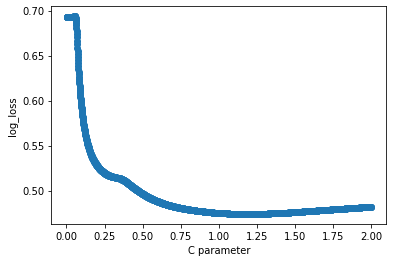

In [ ]:
import matplotlib.pyplot as plt

x = grid['C']
y = results.cv_results_['mean_test_score']
y = -y
plt.scatter(x,y)
plt.xlabel('C')
plt.ylabel('log_loss')
plt.show()

**Logistic Regression**

In [ ]:

import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel


In [ ]:
# scaler = StandardScaler()
# scaler.fit(X_train.fillna(0))

In [ ]:
# load the dataset
predictor_var = ['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']
outcome_var = 'diagnosis_SPMS'
X_train, X_test, y_train, y_test = train_test_split(df_all_treated[predictor_var], df_all_treated[outcome_var])


** Logistic Regeression **

In [ ]:
sel_ = SelectFromModel(LogisticRegression(C=(1.206), penalty='l1', solver='liblinear'))
print(X_train)
print(y_train)

# lab_enc = preprocessing.LabelEncoder()
# encoded = lab_enc.fit_transform(y_train)
sel_.fit(X_train, y_train)

In [ ]:
sel_.get_support()


array([ True, False, False, False,  True, False, False,  True, False,
        True, False])

In [ ]:
selected_feat = X_train.columns[(sel_.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
      np.sum(sel_.estimator_.coef_ == 0)))

total features: 11
selected features: 4
features with coefficients shrank to zero: 7


Number of features which coefficient was shrank to zero


In [ ]:
np.sum(sel_.estimator_.coef_ == 0)

7

 Identifying the removed features

In [ ]:
removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
removed_feats

Index(['TIGIT_RQ', 'LAG3_RQ', 'age_at_diagnosis', 'MRI_lesion_mass',
       'Lymph_Cells', 'Cells', 'oligoclonal_band_POS'],
      dtype='object')

In [ ]:
selected_feats_pos_coef = X_train.columns[(sel_.estimator_.coef_ > 0).ravel().tolist()]
selected_feats_neg_coef = X_train.columns[(sel_.estimator_.coef_ < 0).ravel().tolist()]
selected_feats = []

for x in selected_feats_pos_coef:
  selected_feats.append(x)
for x in selected_feats_neg_coef:
  selected_feats.append(x)

selected_feats

['primary_EDSS_at_diagnosis', 'PMN_Cells', 'gender_M', 'TIM3_RQ']

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000)
predictor_var1 = ['primary_EDSS_at_diagnosis', 'PMN_Cells', 'gender_M', 'TIM3_RQ']
outcome_var = 'diagnosis_SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_all_treated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))


0.8977272727272727
0.5625


#EDSS POST 10 YEARS - not used for now

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV
# from sklearn.datasets import fetch_california_housing
# from sklearn.model_selection import GridSearchCV


# # grid = search
# alphas = arange(0, 1, 0.01)

# train_scores_mean = search.cv_results_["mean_train_score"]
# train_scores_std = search.cv_results_["std_train_score"]
# test_scores_mean = search.cv_results_["mean_test_score"]
# test_scores_std = search.cv_results_["std_test_score"]

# plt.figure()
# plt.title('Model')
# plt.xlabel('$\\alpha$ (alpha)')
# plt.ylabel('Score')
# # plot train scores
# plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
#              color='navy')
# # create a shaded area between [mean - std, mean + std]
# plt.gca().fill_between(alphas,
#                        train_scores_mean - train_scores_std,
#                        train_scores_mean + train_scores_std,
#                        alpha=0.2,
#                        color='navy')
# plt.semilogx(alphas, results,
#              label='Mean Test score', color='darkorange')

# # create a shaded area between [mean - std, mean + std]
# plt.gca().fill_between(alphas,
#                        test_scores_mean - test_scores_std,
#                        test_scores_mean + test_scores_std,
#                        alpha=0.2,
#                        color='darkorange')

# plt.legend(loc='best')
# plt.show()

In [ ]:
# # make a prediction with a lasso regression model on the dataset
# from sklearn.linear_model import Lasso

# # load the dataset
# predictor_var = ['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']
# outcome_var = 'EDSS_post_10_years'
# X_train, X_test, y_train, y_test = train_test_split(df_all_treated[predictor_var], df_all_treated[outcome_var])

# # define model
# model = Lasso(alpha=0.04)
# # fit model
# model.fit(X_train, y_train)
# # make a prediction
# y_predicted_lasso = model.predict(X_test)
# # summarize prediction
# print(y_test.values)
# print("*****")
# print(y_predicted_lasso)

[1.5 2.  6.  2.5 2.  3.  7.5 9.  5.  2.  6.  6.5 2.  4.  6.  3.5 1.  1.
 0.  4.  3.5 5.  6.  1.  7.5 2.  7.  8.5 5.5 8.  1.  5.  3.  0. ]
*****
[4.14421415 1.86609374 4.48772721 1.1697383  2.21375927 1.80066721
 4.57520083 5.52519453 2.35369839 4.3034401  2.00633764 5.74288228
 4.18107203 2.33352282 2.3696513  1.78302441 2.28688219 3.63167399
 1.12809417 2.40865576 2.31634406 2.04619292 3.26904385 1.53079454
 4.8325761  3.23694135 4.86746676 2.37663692 6.6133305  2.41928894
 4.85013341 5.49390642 2.2505053  2.04385187]


RMSE

In [ ]:
  # rmse = sqrt(mean_squared_error(y_test, y_predicted_lasso))  
  # print(rmse)
  

2.0607179713841095


Cross Validation RMSE

In [ ]:
# def calcCrossValidation_RMSE(model, df, predictors, outcome):


#   # Perform k-fold cross-validation with 10 folds
#   kf = KFold(n_splits=df.shape[0])
#   accuracy = []
#   total_RMSE=0
#   for train, test in kf.split(df):
#       # print(train)
#       # Filter training data
#       train_predictors = (df[predictors].iloc[train, :])
#       # The target we're using to train the algorithm.
#       train_target = df[outcome].iloc[train]
#       test_predictors = (df[predictors].iloc[test, :])
#       # print(train_predictors)

#       # The target we're using to train the algorithm.
#       test_target = df[outcome].iloc[test]

#       # Training the algorithm using the predictors and target.
#       model.fit(train_predictors, train_target)
#       predictions = model.predict(test_predictors)
#       # print(predictions)
#       rmse = sqrt(mean_squared_error(test_target, predictions))  
#       # print(rmse)
#       total_RMSE += rmse

#   return total_RMSE/df.shape[0]

In [ ]:
# rmse = calcCrossValidation_RMSE(model, df_all_treated, predictor_var, outcome_var)
# print(rmse)

1.5780522012835085


# Random Forest Regressor feature selection -- not used for now

In [ ]:
sel = SelectFromModel(RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15), threshold='0.7*mean')
print(X_train)
print(y_train)

# lab_enc = preprocessing.LabelEncoder()
# encoded = lab_enc.fit_transform(y_train)
sel.fit(X_train, y_train)

In [ ]:
sel.get_support()


array([ True, False, False,  True,  True, False, False, False, False,
       False, False])

In [ ]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

3

In [ ]:
print(selected_feat)


Index(['TIM3_RQ', 'age_at_diagnosis', 'primary_EDSS_at_diagnosis'], dtype='object')


In [ ]:
from sklearn.metrics import confusion_matrix
randomForestRegr = RandomForestRegressor(n_estimators = 10, random_state = 42)
predictor_rmse = ['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass']
outcome_rmse = 'EDSS_post_10_years'
rmse = calcCrossValidation_RMSE(randomForestRegr, df_all_treated, predictor_rmse, outcome_rmse)
print(rmse)

1.677205882352942


#**SHAP**

In [ ]:
!pip install shap


     |████████████████████████████████| 358kB 8.3MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491624 sha256=803f4a6897b6f8dfe525f9d8dcac758a6a5f7ee1cc589092566d139ded618894
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


**EDSS_POST_10_YEARS**

random forest regressor all features

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
df = df_all_treated
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# The target variable is 'quality'.
Y = df['EDSS_post_10_years']
X =  df[['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
# Build the model with the random forest regression algorithm:
model = randomForestRegr = RandomForestRegressor(n_estimators = 10, random_state = 42)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

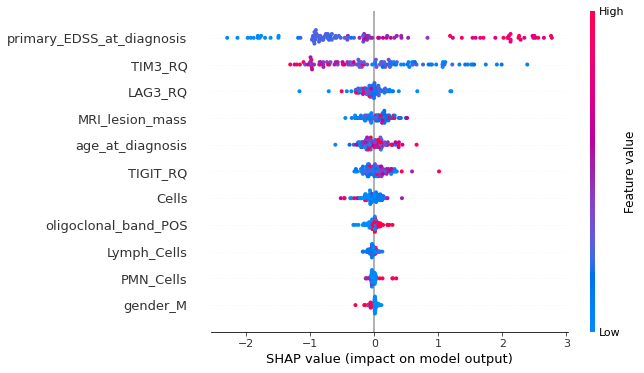

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

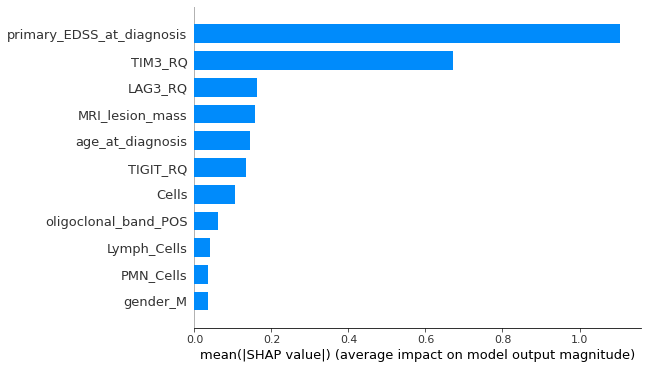

In [ ]:

shap.summary_plot(shap_values, X_train, plot_type="bar")


logistic regression all features SPMS\RRMS SHAP

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
df = df_all_treated
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# The target variable is 'quality'.
Y = df['diagnosis_SPMS']
X =  df[['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
# Build the model with the random forest regression algorithm:
model = logisticRegrDF = LogisticRegression(max_iter = 4000)
model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=4000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

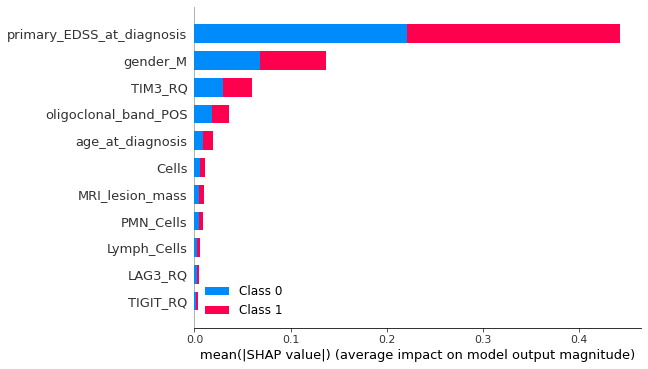

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:
predict = model.predict_proba(X_test)
predict

array([[0.81614447, 0.18385553],
       [0.68489647, 0.31510353],
       [0.24207013, 0.75792987],
       [0.82446523, 0.17553477],
       [0.88598397, 0.11401603],
       [0.87415128, 0.12584872],
       [0.13937708, 0.86062292],
       [0.42623085, 0.57376915],
       [0.76905578, 0.23094422],
       [0.85128638, 0.14871362],
       [0.07503652, 0.92496348],
       [0.22991355, 0.77008645],
       [0.11430793, 0.88569207],
       [0.93786139, 0.06213861],
       [0.61188562, 0.38811438],
       [0.25272376, 0.74727624],
       [0.66046814, 0.33953186],
       [0.76794597, 0.23205403],
       [0.82293077, 0.17706923],
       [0.81609128, 0.18390872],
       [0.73092924, 0.26907076],
       [0.09896865, 0.90103135],
       [0.79468006, 0.20531994],
       [0.84926164, 0.15073836],
       [0.80627832, 0.19372168],
       [0.68937458, 0.31062542],
       [0.41353581, 0.58646419],
       [0.61703651, 0.38296349]])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

logistic regression USING LASSO SPMS\RRMS SHAP

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
df = df_all_treated
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
# The target variable is 'quality'.
Y = df['diagnosis_SPMS']
X =  df[['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
# Build the model with the random forest regression algorithm:
model = LogisticRegression(C=(1.206), penalty='l1', solver='liblinear')
model.fit(X_train, Y_train)

LogisticRegression(C=1.206, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

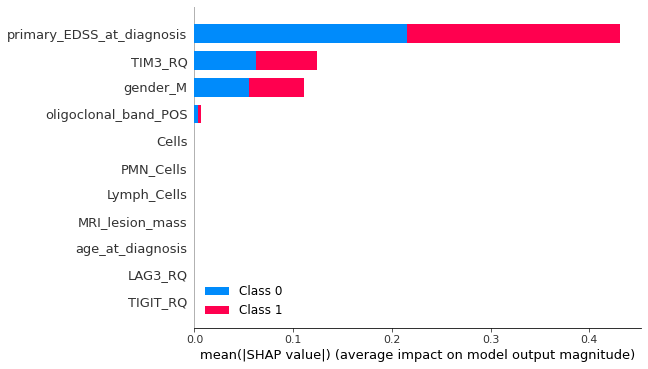

In [ ]:
import shap
explainer = shap.KernelExplainer(model.predict_proba, X_test)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [ ]:
predict = model.predict_proba(X_test)
predict

array([[0.7426964 , 0.2573036 ],
       [0.71864776, 0.28135224],
       [0.22042513, 0.77957487],
       [0.80030687, 0.19969313],
       [0.94048023, 0.05951977],
       [0.95364334, 0.04635666],
       [0.10654905, 0.89345095],
       [0.46065455, 0.53934545],
       [0.81055021, 0.18944979],
       [0.86310946, 0.13689054],
       [0.09030087, 0.90969913],
       [0.23099588, 0.76900412],
       [0.10867176, 0.89132824],
       [0.92078748, 0.07921252],
       [0.54898904, 0.45101096],
       [0.32100603, 0.67899397],
       [0.68684447, 0.31315553],
       [0.74972752, 0.25027248],
       [0.93179567, 0.06820433],
       [0.7627937 , 0.2372063 ],
       [0.73369812, 0.26630188],
       [0.14435224, 0.85564776],
       [0.83210123, 0.16789877],
       [0.87129304, 0.12870696],
       [0.81453013, 0.18546987],
       [0.73138031, 0.26861969],
       [0.45881981, 0.54118019],
       [0.58184535, 0.41815465]])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test.iloc[0,:], link="logit")


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test, link="logit")

diagnosis_SPMS

#xgboost

[15:08:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


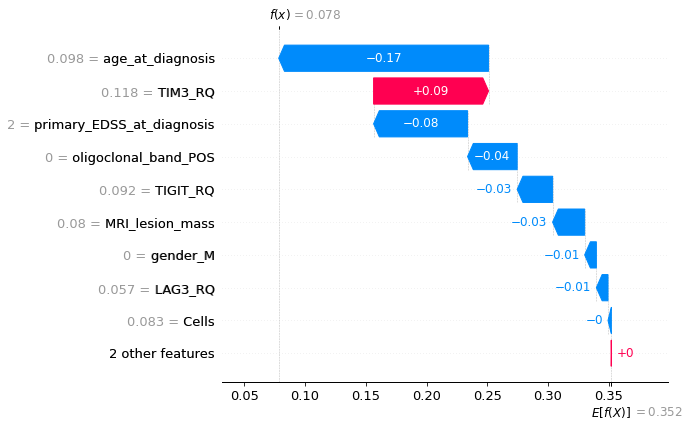

In [ ]:
import xgboost
import shap

# train an XGBoost model
predictor_var = ['TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ','age_at_diagnosis', 'primary_EDSS_at_diagnosis', 'MRI_lesion_mass','Lymph_Cells','PMN_Cells','Cells','gender_M','oligoclonal_band_POS']
outcome_var = 'diagnosis_SPMS'
X = df_all_treated[predictor_var]
y = df_all_treated[outcome_var]
# X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# **WITH FEATURE SELECTION FROM LASSO **

In [ ]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
df = df_all_treated
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
# The target variable is 'quality'.
Y = df['diagnosis_SPMS']
X =  df[['primary_EDSS_at_diagnosis', 'gender_M', 'TIM3_RQ']]
# Split the data into train and test data:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
# Build the model with the random forest regression algorithm:
model = RandomForestClassifier(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

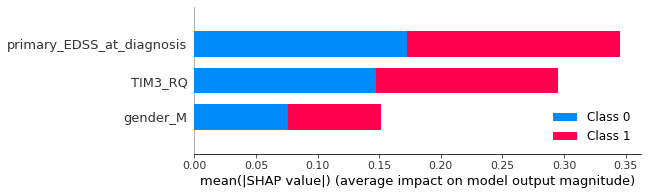

In [ ]:
import shap
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

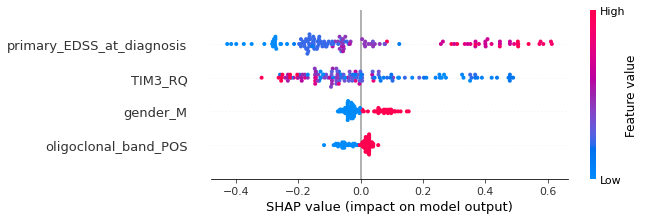

In [ ]:
shap.plots.beeswarm(shap_values)

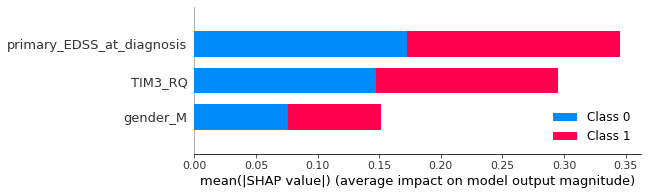

In [ ]:
shap.summary_plot(shap_values, X_train)

[13:18:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


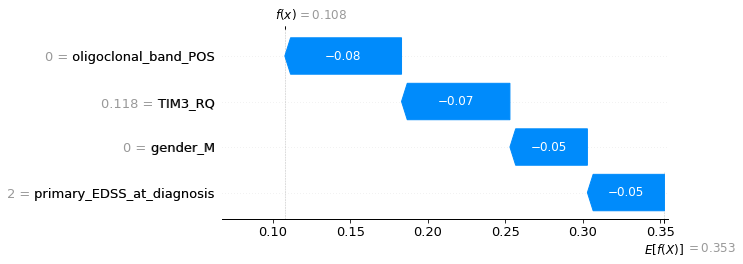

In [ ]:
import xgboost
import shap

# train an XGBoost model
predictor_var = ['primary_EDSS_at_diagnosis', 'gender_M', 'oligoclonal_band_POS', 'TIM3_RQ']
outcome_var = 'diagnosis_SPMS'
X = df_all_treated[predictor_var]
y = df_all_treated[outcome_var]
# X, y = shap.datasets.boston()
model = xgboost.XGBRegressor().fit(X, y)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])